### Load relevant packages and data

In [4]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import re
import calendar
import numpy as np
from datetime import datetime, timedelta



hour_name = ["12am"]+[str(i)+"am" for i in range(1,12)]+["12pm"]+[str(i)+"pm" for i in range(1,12)]
day_name = list(calendar.day_name)
month_name = list(calendar.month_name)

calendar_label_dict = {"hour" : hour_name, "dayOfWeek": day_name, "month": month_name}



def to_camel(col_name):
    split_col_name = re.split( "_| ", col_name)
    
    if len(split_col_name)>1:
        
        col_name = "".join([x.capitalize() for x in split_col_name])
  
    col_name = col_name[0].lower()+col_name[1:]
    
    return col_name

def standardise(x):
    return (x-np.mean(x))/np.std(x)

def rolling_average(days, x, df, column_to_aggregate):
    return df[(df["date"]<=x) & (df["date"]>=(x- timedelta(days=days)))][column_to_aggregate].mean()

def rolling_sum(days, x, df, column_to_aggregate):
    return df[(df["date"]<=x) & (df["date"]>=(x- timedelta(days=days)))][column_to_aggregate].sum()


def window(df, grouper, agg_field, aggregation, new_col_name):
    # This function performs a similar function to pysparks window function. We want to partition the data by
    # grouper, and perform an aggregation over agg_field
        
    # Partition the data by the grouper
    gdf = df.groupby(grouper).agg({agg_field:[aggregation]}).reset_index()

    gdf.columns =  [grouper] + [new_col_name]


    # Merge back to original dataframe
    df = pd.merge(df, gdf, on=grouper, how="left")

    return df


os.chdir("C:/Users/timur/WB Datasets/")


trx_data = pd.read_csv("exercise_2_train_transaction.csv")

trx_data = trx_data[["TransactionID", "isFraud","TransactionDT","TransactionAmt","ProductCD","card1","card2","card3","card4","card5","card6","addr1","addr2","dist1","dist2","P_emaildomain","R_emaildomain"]].drop_duplicates()


### Standardise column names to camel case, and see how many unique values each column has (this may point to columns which identify the unique card)

In [5]:
trx_data.columns = trx_data.columns.to_series().apply(lambda x: to_camel(x))
trx_data.nunique()

transactionID     590540
isFraud                2
transactionDT     573349
transactionAmt     20902
productCD              5
card1              13553
card2                500
card3                114
card4                  4
card5                119
card6                  4
addr1                332
addr2                 74
dist1               2651
dist2               1751
pEmaildomain          59
rEmaildomain          60
dtype: int64

Is card1 the unique identify of the card?

### View data and create a date columns

In [115]:
trx_data.sample(n=20)

,transactionID,isFraud,transactionDT,transactionAmt,productCD,card1,card2,card3,card4,card5,...,v336,v337,v338,v339,transactionDate,date,dayOfWeek,hour,month,dayOfMonth
390810,3377810,0,9818024,30.950,W,15224,248.0,150.0,mastercard,166.0,...,NaN,NaN,NaN,NaN,2011-04-02 15:13:44,2011-04-02,5,15,4,2
479694,3466694,0,12446976,59.000,W,8089,NaN,150.0,visa,195.0,...,NaN,NaN,NaN,NaN,2011-05-03 01:29:36,2011-05-03,1,1,5,3
133804,3120804,0,2669717,108.500,W,7919,194.0,150.0,mastercard,202.0,...,NaN,NaN,NaN,NaN,2011-01-09 21:35:17,2011-01-09,6,21,1,9
586294,3573294,0,15696002,100.000,R,6019,583.0,150.0,visa,226.0,...,100.0,100.0,100.0,100.0,2011-06-09 16:00:02,2011-06-09,3,16,6,9
358519,3345519,0,8886150,49.000,W,8315,538.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,2011-03-22 20:22:30,2011-03-22,1,20,3,22
233025,3220025,0,5517728,117.000,W,5699,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,2011-02-11 20:42:08,2011-02-11,4,20,2,11
197520,3184520,0,4469535,57.950,W,5017,432.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,2011-01-30 17:32:15,2011-01-30,6,17,1,30
573273,3560273,1,15219597,250.000,R,1724,583.0,150.0,visa,226.0,...,0.0,0.0,0.0,0.0,2011-06-04 03:39:57,2011-06-04,5,3,6,4
358757,3345757,0,8889869,14.501,C,14276,177.0,185.0,mastercard,137.0,...,NaN,NaN,NaN,NaN,2011-03-22 21:24:29,2011-03-22,1,21,3,22
35927,3022927,0,870638,38.970,W,11727,301.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,2010-12-20 01:50:38,2010-12-20,0,1,12,20


In [6]:
# transactionDT is the time delta in seconds. Dividing by (60*60*24) will give us the number of days.  Get the max delta day
trx_data["transactionDT"].max()/(60*60*24)

182.99920138888888

In [7]:
# Given that the data spans 183 days, assume an origin date such that it doesn't exceed the current date, i.e. 2010-01-01 and time 00:00:00
trx_data["transactionDate"]  =  pd.to_datetime(trx_data["transactionDT"],unit='s', origin=pd.Timestamp('2010-12-10 00:00:00'))
trx_data['date'] = trx_data["transactionDate"].dt.date
trx_data['date'] =  pd.to_datetime(trx_data['date'])

trx_data['dayOfWeek'] = trx_data["transactionDate"].dt.dayofweek
trx_data['hour'] = trx_data["transactionDate"].dt.hour
trx_data['month'] = trx_data["transactionDate"].dt.month
trx_data['dayOfMonth'] = trx_data["transactionDate"].dt.day
trx_data

,transactionID,isFraud,transactionDT,transactionAmt,productCD,card1,card2,card3,card4,card5,...,dist1,dist2,pEmaildomain,rEmaildomain,transactionDate,date,dayOfWeek,hour,month,dayOfMonth
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,19.0,NaN,NaN,NaN,2010-12-11 00:00:00,2010-12-11,5,0,12,11
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,gmail.com,NaN,2010-12-11 00:00:01,2010-12-11,5,0,12,11
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,287.0,NaN,outlook.com,NaN,2010-12-11 00:01:09,2010-12-11,5,0,12,11
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,yahoo.com,NaN,2010-12-11 00:01:39,2010-12-11,5,0,12,11
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,NaN,NaN,gmail.com,NaN,2010-12-11 00:01:46,2010-12-11,5,0,12,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,48.0,NaN,NaN,NaN,2011-06-10 23:57:27,2011-06-10,4,23,6,10
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,gmail.com,NaN,2011-06-10 23:57:29,2011-06-10,4,23,6,10
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,gmail.com,NaN,2011-06-10 23:57:59,2011-06-10,4,23,6,10
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,3.0,NaN,aol.com,NaN,2011-06-10 23:58:08,2011-06-10,4,23,6,10


### Analyze temporal patterns in transactions
Note these patterns are dependent on the origin we set above. I am going discuss the results on the assumption that the origin is correct

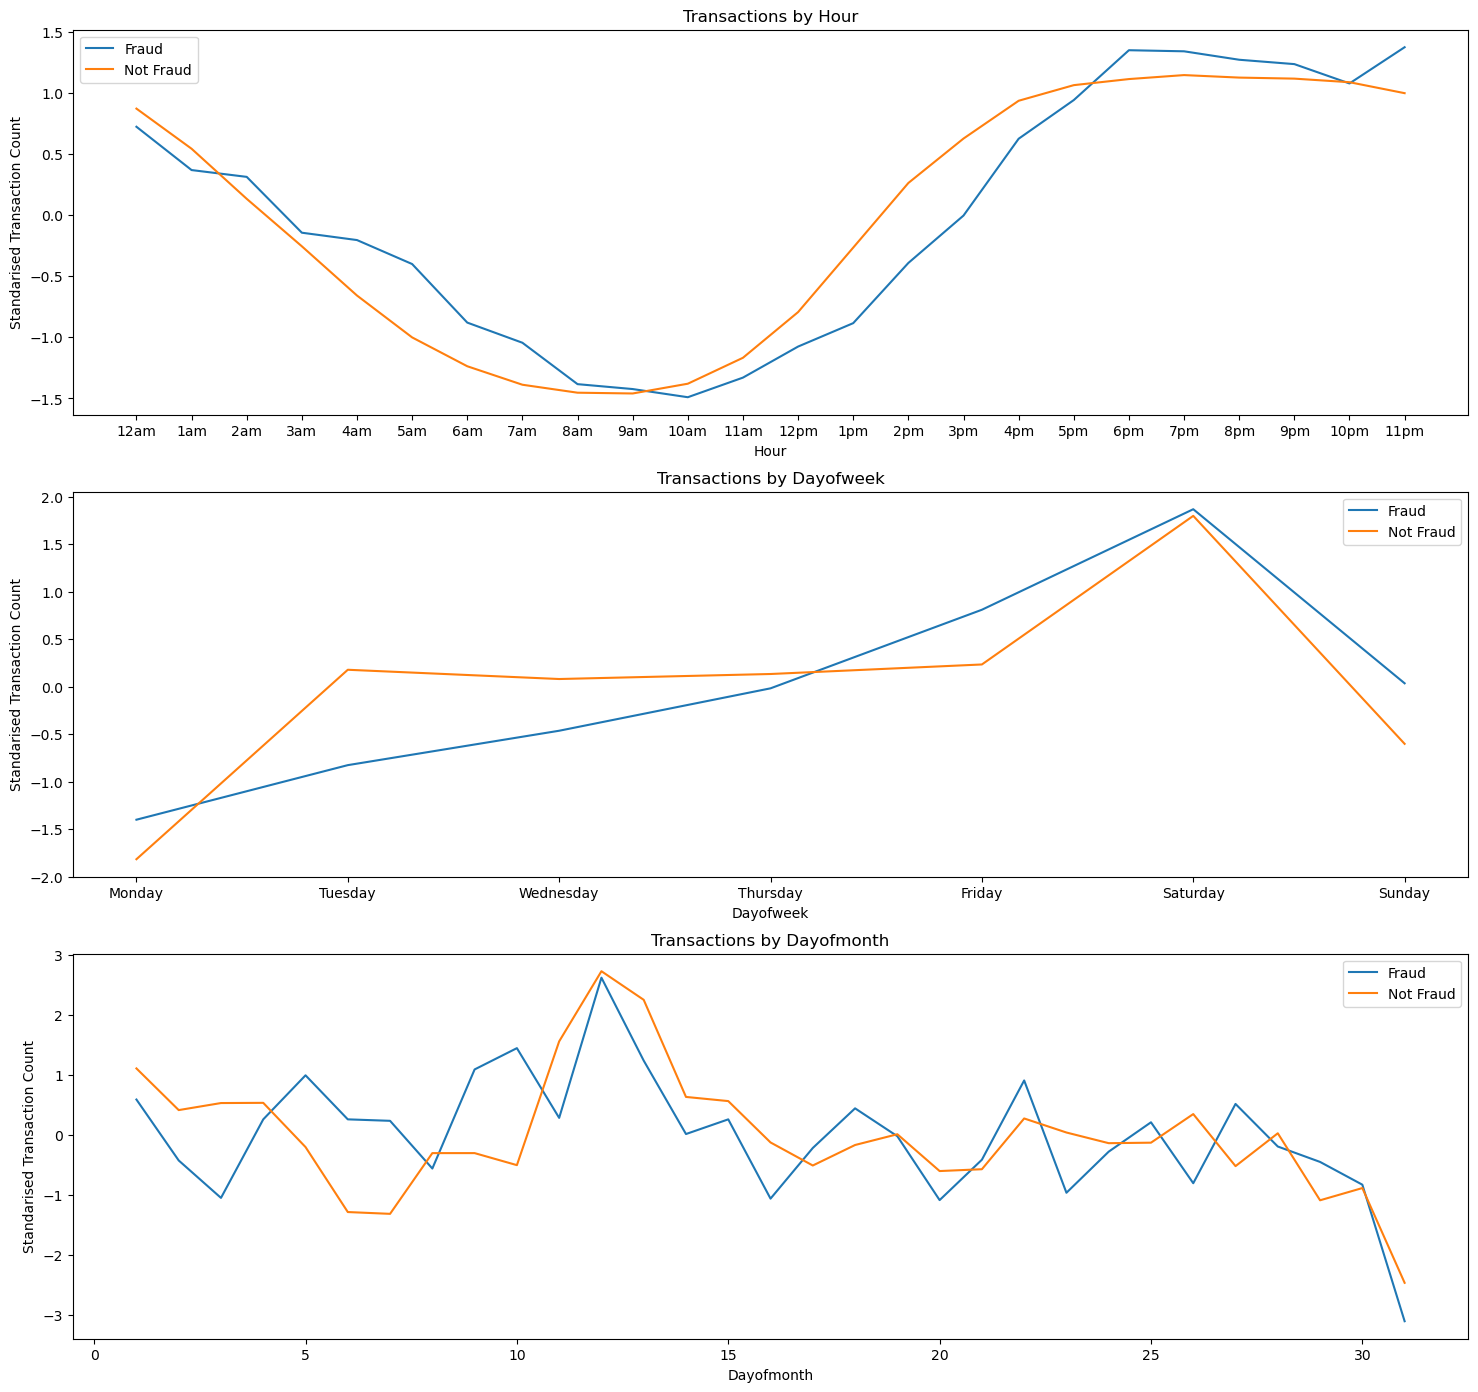

In [8]:

# Create hourly, monthly and daily aggregates. 


aggregation_periods = ["hour", "dayOfWeek", "dayOfMonth"]


# Initialise the subplot 
figure, axis = plt.subplots(3, 1, figsize=(18,17))

for i in range(0,3):
    aggregation_period = aggregation_periods[i]
    agg_trx = trx_data.groupby([aggregation_period, "isFraud"]).agg({"transactionID": ["count"], "transactionAmt": ["sum"]}).reset_index()
    agg_trx.columns = [aggregation_period , "isFraud", "transactionCount", "transactionAmount"]

    agg_trx_fraud_x = agg_trx[agg_trx["isFraud"]==1][aggregation_period].tolist()
    agg_trx_not_fraud_x = agg_trx[agg_trx["isFraud"]==0][aggregation_period].tolist()
    # Standardise counts so we can view both fraudulent and non-fraudulent on one chart
    agg_trx_fraud_y = standardise(agg_trx[agg_trx["isFraud"]==1]["transactionCount"].tolist())
    agg_trx_not_fraud_y = standardise(agg_trx[agg_trx["isFraud"]==0]["transactionCount"].tolist())


    

  
    axis[i].plot(agg_trx_fraud_x , agg_trx_fraud_y, label="Fraud", )
    axis[i].plot(agg_trx_not_fraud_x , agg_trx_not_fraud_y, label="Not Fraud" )
    axis[i].legend()


    axis[i].set_title("Transactions by "+aggregation_period.capitalize())

    if aggregation_period != "dayOfMonth":
        agg_trx_not_fraud_x_labels = [calendar_label_dict[aggregation_period][x] for x in agg_trx_not_fraud_x]
        axis[i].set_xticks(agg_trx_not_fraud_x, labels=agg_trx_not_fraud_x_labels)
    axis[i].set_ylabel('Standarised Transaction Count')
    axis[i].set_xlabel(aggregation_period.capitalize())

plt.show()



In the above plots we can see fraudulent activity peak at 6pm, an hour after non-fraudulent transaction peak. It appears that fraudulent transactions lag non-fraudulent transactions by about an hour.  This may be because a non-fraudulent transaction is conducted and it is this transactions which leads to credit card details being compromised. Shortly after the the credit card is used for fraudulent transaction. 

Unlike the day the time of the day, there doesn't appear as strong a correlation between fraudulent and non-fraudulent transactions when we look at the day of the week. The non-fraudulent transaction begining to increase on Friday, peaking on Saturday. This would be the period when people go out and spend money. Given the hypothesis above it makes sense that fraudulent transactions also peak on Saturday, given that is when credit card spending is most frequent. There may also be less fraudulent transactions during the week as people are more likely to spend on their credit cards where there are less chances of credit card details being compromised, for example at the super market or local cafe

### Create moving averages and identify seasonal trends (also includes window like functions)



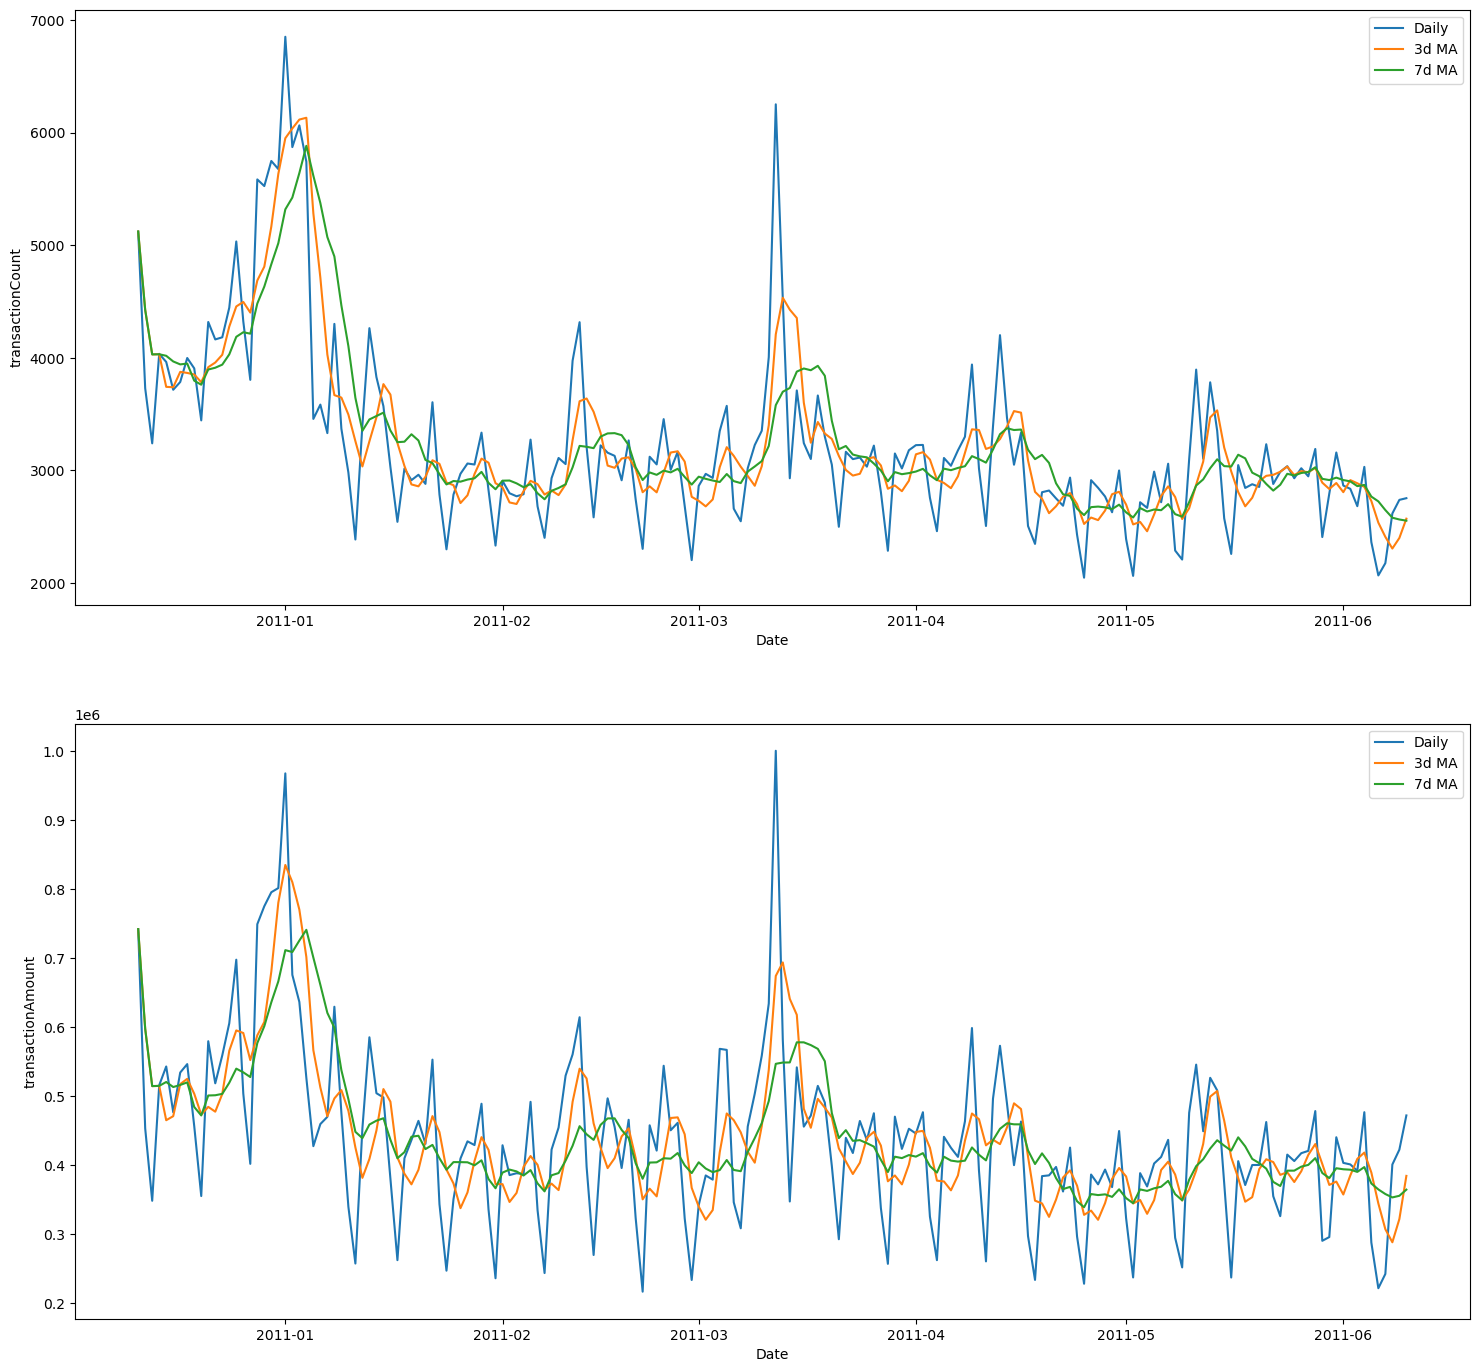

In [9]:
# Aggregate over transaction date
daily_trx = trx_data.groupby(["date"]).agg({"transactionID": ["count"], "transactionAmt": ["sum"]}).reset_index()
daily_trx .columns = ["date", "transactionCount", "transactionAmount"]


daily_trx = daily_trx.sort_values(by="date")
figure, axis = plt.subplots(2, 1, figsize=(18,17))

for i in range(0,2):  
    column_to_aggregate = ["transactionCount", "transactionAmount"][i]
    daily_trx ["3dMA"] = daily_trx ["date"].apply(lambda x: rolling_average(3,x, daily_trx, column_to_aggregate ))
    daily_trx ["7dMA"] = daily_trx ["date"].apply(lambda x: rolling_average(7, x, daily_trx, column_to_aggregate ))
    
    axis[i].plot(daily_trx ["date"], daily_trx [column_to_aggregate], label="Daily")
    axis[i].plot(daily_trx  ["date"], daily_trx ["3dMA"], label="3d MA")
    axis[i].plot(daily_trx  ["date"], daily_trx ["7dMA"], label="7d MA")
    axis[i].set_xlabel("Date")
    axis[i].set_ylabel(column_to_aggregate)
    axis[i].legend()
plt.show()


In the above chart we see the number of transaction is higher in December, which is the Christmas period.

### Develop statistical measures for anomaly detection

# Deviation by transaction amount
# Deviation by transaction frequency
# Spending beyond what the entity normally spends
# Spending in times that are not inline with the person

(array([5134., 3044., 2528., 1511.,  726.,  325.,  154.,   90.,   32.,
           9.]),
 array([0.        , 0.96112618, 1.92225237, 2.88337855, 3.84450474,
        4.80563092, 5.7667571 , 6.72788329, 7.68900947, 8.65013566,
        9.61126184]),
 <BarContainer object of 10 artists>)

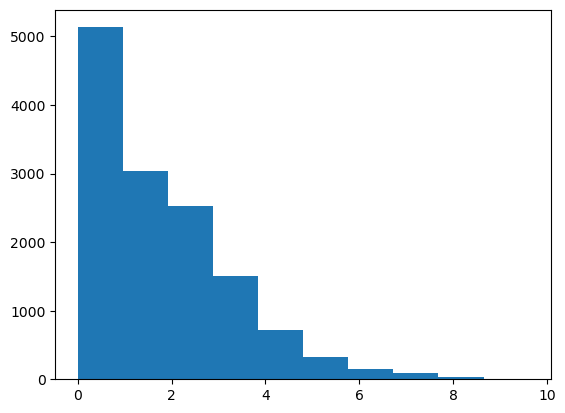

In [19]:
trx_data.groupby(["isFraud", "productCD"]).agg({"transactionAmt":["mean", "std"]})

tmp = trx_data.groupby(["card1"]).agg({"transactionID":["count"], "transactionAmt":["mean", "std"]}).reset_index()
tmp.columns = ["card1", "count", "mean", "std"]
tmp.sort_values(by="count")

plt.hist(np.log(tmp["count"]))